In [1]:
# Disable TensorFlow debugging info and warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 2: Info and warnings not displayed 

In [26]:
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
import matplotlib.colors
import pathlib
import tqdm
import annotation, misc, hyspec_io, image_render, hyspec_ml, hyspec_cnn, preprocess
import skimage.exposure
import tensorflow as tf
import sklearn.metrics

In [3]:
# Disable GPUs
tf.config.set_visible_devices([], 'GPU')
visible_devices = tf.config.get_visible_devices()
for device in visible_devices:
    assert device.device_type != 'GPU'

In [4]:
# Paths
json_gray = pathlib.Path('/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/M_Annotation/20210825_Olbergholmen_Annotation_20230228_gray/label_classes.json')
validation_images_dir = pathlib.Path('/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/5b_Rad_Georef_SGC_PCA_TrainValSplit/Validation_Images')
unet_model_path = pathlib.Path('/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/X_SavedKerasModels/InpaintedDataset_TestImages-12-17-24/20230511_Unet_Depth2_UsingReduceLrOnPlateau/unet_model.epoch40-loss0.028375-acc0.887.hdf5')

In [13]:
# Parameters
PAD_MULTIPLE = 2**5

# Instructions for merging / extracting classes
classes_to_merge = [['Zostera marina - dominant','Zostera marina - normal','Zostera marina - sparse'],
                    ['Rockweed','Rockweed with turf algae','Fucus serratus','Saccharina latissima'],
                    ['Turf algae - dominant','Turf algae - normal','Turf algae - sparse','Aegagropila (algae ball)']]
merged_class_names = ['Zostera marina',
                      'Rockweed',
                      'Other algae']
classes_to_extract = ['Sand',
                      'Zostera marina',
                      'Zostera marina with turf algae',
                      'Rockweed',
                      'Other algae']

# Colormap
custom_cmap = matplotlib.colors.ListedColormap(colors=['black','aqua','yellowgreen','lightgreen','brown','violet'])

In [6]:
# Read annotation metadata file, show classes
class_dict = annotation.read_hasty_metadata(json_gray)

In [7]:
# Load images, pad, merge classes 
pca_images = []
label_images = []
dataset_paths = validation_images_dir.glob('*')
for dataset_path in dataset_paths:
    dataset = tf.data.experimental.load(str(dataset_path))
    pca_im, label_im = [d for d in dataset.as_numpy_iterator()][0]
    pca_im = hyspec_cnn.pad_image_to_multiple(pca_im,PAD_MULTIPLE)
    label_im = hyspec_cnn.pad_image_to_multiple(label_im,PAD_MULTIPLE)
    
    # Read and filter image (class mask)
    merged_class_dict, merged_class_mask = annotation.merge_classes_with_mask(
        class_dict,label_im,classes_to_merge,merged_class_names)
    filtered_class_dict, filtered_class_mask = annotation.extract_subset(
        merged_class_dict,merged_class_mask,classes_to_extract)
    
    pca_images.append(pca_im)
    label_images.append(filtered_class_mask)
    

In [8]:
# Load UNet model, recompile to handle different TensorFlow version in Docker 
unet = tf.keras.models.load_model(str(unet_model_path),compile=False)
unet.compile(optimizer=tf.keras.optimizers.RMSprop(0.0001), 
             loss="sparse_categorical_crossentropy",
             weighted_metrics=['sparse_categorical_accuracy'], 
             metrics = []) 

In [9]:
# Run Unet on validation dataset
label_images_unet = []
for pca_im in pca_images:
    pred_im = hyspec_cnn.unet_classify_single_image(unet,pca_im) * np.all(pca_im!=0,axis=2)
    label_images_unet.append(pred_im)

1/1 [==============================] - 2s 2s/step


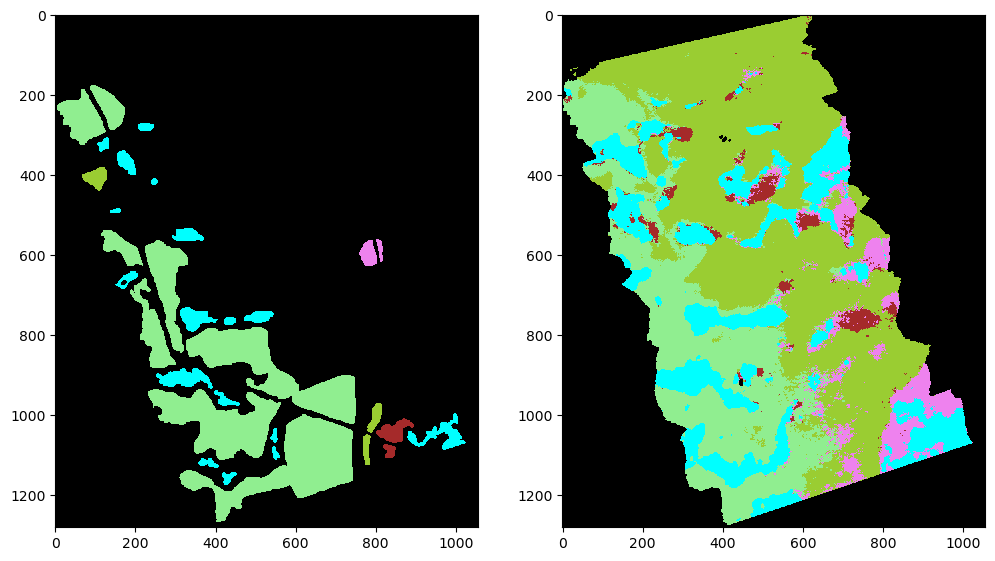

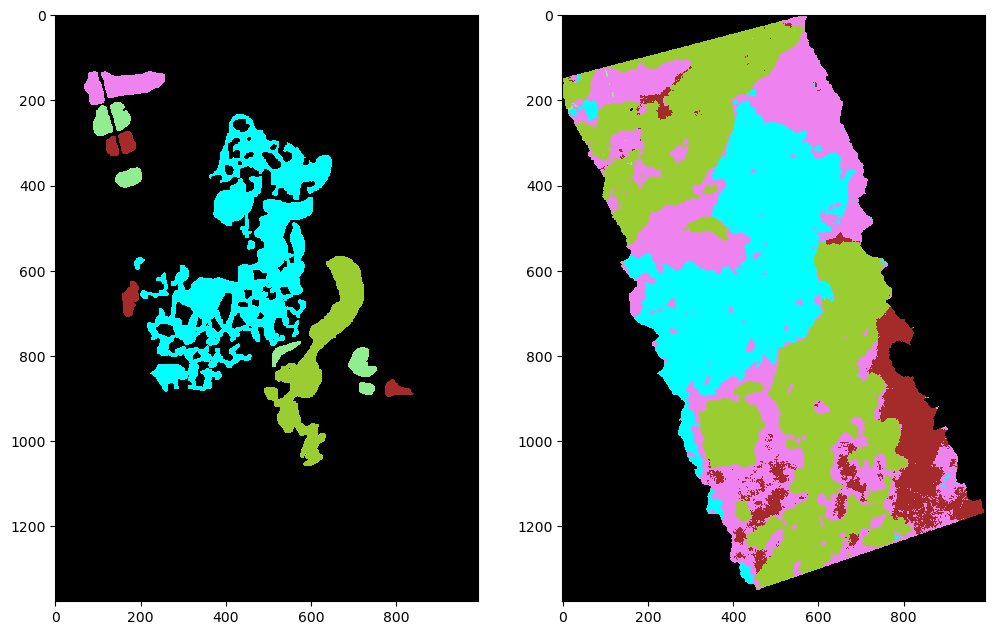

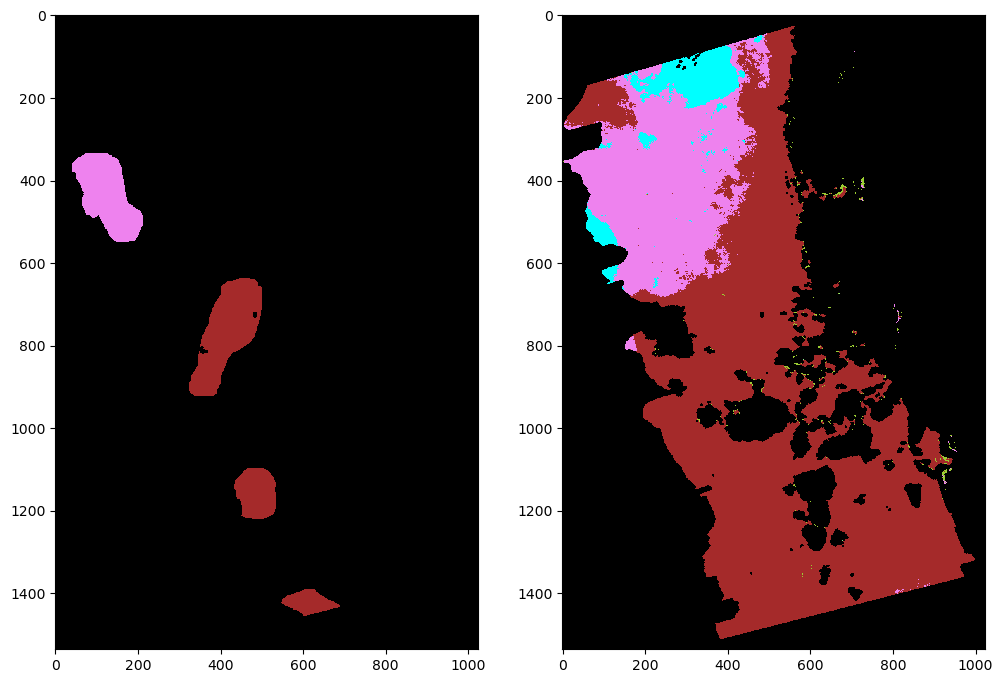

In [20]:
for label_im, label_im_pred in zip(label_images,label_images_unet):
    fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(12,12))
    im1 = ax1.imshow(label_im,interpolation='none',cmap=custom_cmap,vmin=0,vmax=5)
    im2 = ax2.imshow(label_im_pred,interpolation='none',cmap=custom_cmap,vmin=0,vmax=5)
    #fig.colorbar(im2,ax=ax2)
    plt.show()

In [22]:
y_true = []
y_unet = []
for label_im_true,label_im_pred in zip(label_images,label_images_unet):
    nonzero_mask = label_im_true>0
    y_true.append(label_im_true[nonzero_mask])
    y_unet.append(label_im_pred[nonzero_mask])
y_true = np.concatenate(y_true)
y_unet = np.concatenate(y_unet)


In [27]:
confusion_matrix = sklearn.metrics.confusion_matrix(y_true,y_unet,normalize='true')

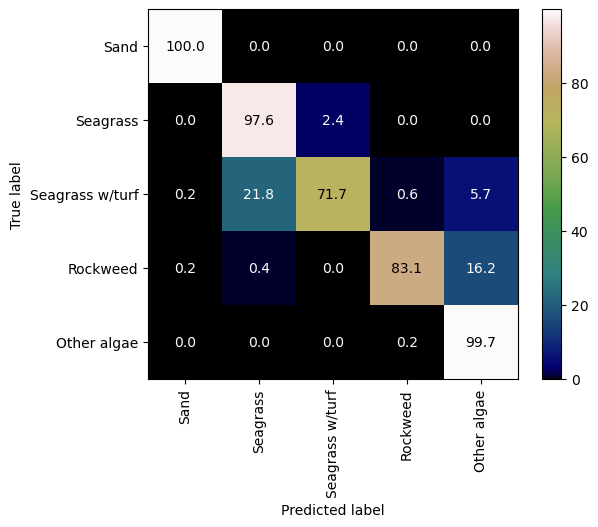

In [28]:
# Show confusion matrix
display_labels = ['Sand', 'Seagrass', 'Seagrass w/turf','Rockweed','Other algae']
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix*100,display_labels=display_labels)
disp.plot(xticks_rotation='vertical',cmap='gist_earth',values_format='.1f')
plt.show()